# Anomaly detection algorithms

Unsupervised anomaly detection algorithms can detect data that does not belong to normal data patterns. In general, it looks for isolated samples, samples that are in low-density regions. Anomaly detection algorithms can be divided into several approaches such as:

-	Density based 
-	Distance based 
-   Kernel based
-	Statistical approaches
-	Tree-based methods 

In this notebook we test a few of these algorithms. The Local Outlier Factor, robust covariance, One Class Support Vector Machine, and the Isolation Forest.

**Local Outlier Factor** LOF compares the density of any given data point to the density of its neighbors. Since outliers come from low-density areas, the ratio will be higher for anomalous data points. As a rule of thumb, a normal data point has a LOF between 1 and 1.5 whereas anomalous observations will have much higher LOF. The higher the LOF the more likely it is an outlier (2).
Density-based methods identify anomalies based on the local density of data points. Anomalies are detected as points that have significantly lower density compared to their neighboring points. Another example next to LOF is  DBSCAN.

**Distance-based** methods determine anomalies by measuring the distance or dissimilarity of data points to their neighboring points. Points that are significantly distant or dissimilar from others are considered anomalies. Examples include k-nearest neighbors (k-NN), distance-based outlier detection (e.g., using Mahalanobis distance or Euclidean distance), and angle-based outlier detection. 

The **robust covariance** method is a **gaussian elipse-based method**. If it is outside the gaussian curve, or on the edges it might be an outlier. It is based on the Mahalanobis distance which assesses how many standard deviations σ away xᵢ is from μ. An extreme observation has a large distance from the center of a distribution. An envelope around the data set can be constructed by choosing a critical value of the Mahalanobis distance. Points outside this envelope are considered anomalies/outliers. (1)

**One Class Support Vector Machine** is cluster method based on the Support Vector Machine algorithm. Instead of separating classes into clusters, it separates one class from the origin. The points outside the boundary line are classified as outliers. It uses kernels. The default kernel is ‘rbf’ since most of the time the boundary is not linear. (3)

**Isolation Forest is a tree-based** method. The Isolation Forest algorithm does not explicitly consider density or neighborhood relationships between data points. Instead, it uses the idea that anomalies can be identified more quickly and easily in the tree structure compared to normal data points. Anomalies are expected to have shorter paths in the tree, as they require fewer splits to be isolated. It uses partitioning to make isolated trees, with the goal that each point is isolated. The more partitioning is needed, the more chance a data point is a regular point. An outlier is much easier to isolate than a regular point.  (4)



[1] Nascimento et all. "A cluster-based algorithm for anomaly detection in time series using Mahalanobis distance." Proceedings on the International Conference on Artificial Intelligence (ICAI). The Steering Committee of The World Congress in Computer Science, Computer Engineering and Applied Computing (WorldComp), 2015. 

[2] Alghushairy, Omar, et al. "A review of local outlier factor algorithms for outlier detection in big data streams." Big Data and Cognitive Computing 5.1 (2020): 1.

[3] Schölkopf, Bernhard, et al. "Support vector method for novelty detection." Advances in neural information processing systems 12 (1999).

[4] Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. "Isolation-based anomaly detection." ACM Transactions on Knowledge Discovery from Data (TKDD) 6.1 (2012): 1-39.



# Hypothesis

Anomaly detection techniques are commonly employed in predictive maintenance strategies to identify abnormal patterns or behaviors in machine data that may indicate impending failures.

By monitoring various sensor readings, operational parameters, or other relevant data from machines, anomaly detection algorithms can learn the normal behavior or expected patterns of the machines during their normal operation. When a deviation from the normal behavior is detected, it may indicate a potential failure or malfunction. The hypothesis is that the sensor readings of a pump will generate not normal values in case of an (upcoming) failure, and these can be determined with anomaly detection. Several algorithms will be used to evaluate the hypothesis 

datasource: https://www.kaggle.com/datasets/nphantawee/pump-sensor-data

## Assignment

Choose at least 1 out of the listed assignments

- Analyze the end result plot to evaluate the algorithm's performance. Look for anomalies identified by the algorithm and compare them to known anomalies or instances of abnormal behavior in the data. Assess whether the algorithm successfully captures these anomalies and if it shows promising results in detecting abnormal patterns. Based on the plot analysis, provide argumentation for the validity of the anomaly detection algorithm hypothesis (see above). Discuss how the algorithm effectively captures anomalies in the time series data and why it is a suitable approach for the use case. Support your argument with references to relevant literature that discuss the effectiveness of the chosen algorithm or similar algorithms in detecting anomalies in time series data.

- To improve data quality for anomaly detection in time series data, we can focus on removing outliers due to sensor reading errors while preserving anomalies. Additionally, performing resampling or aggregation can help reduce noise and highlight higher-level patterns relevant for anomaly detection. Find common steps to improve data quality for this particular use and implement those. Evaluate the performance of the algorithms compare to the original notebook. 

- Try another algorithm that has not been tested in the notebook. Provide argumentation for the validity of the anomaly detection algorithm you choose. 
- Try to find the best configuration for one of the tested algorithms
- Try anomaly detection on a different dataset without timeseries data. Evaluate the outcome


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# The data

In [22]:
# source: https://www.kaggle.com/datasets/nphantawee/pump-sensor-data
df = pd.read_csv('data/sensor.csv').drop('Unnamed: 0', axis=1)
df_origin = df.copy()

## Inspect data

In [3]:
df.shape

(220320, 54)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 54 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   timestamp       220320 non-null  object 
 1   sensor_00       210112 non-null  float64
 2   sensor_01       219951 non-null  float64
 3   sensor_02       220301 non-null  float64
 4   sensor_03       220301 non-null  float64
 5   sensor_04       220301 non-null  float64
 6   sensor_05       220301 non-null  float64
 7   sensor_06       215522 non-null  float64
 8   sensor_07       214869 non-null  float64
 9   sensor_08       215213 non-null  float64
 10  sensor_09       215725 non-null  float64
 11  sensor_10       220301 non-null  float64
 12  sensor_11       220301 non-null  float64
 13  sensor_12       220301 non-null  float64
 14  sensor_13       220301 non-null  float64
 15  sensor_14       220299 non-null  float64
 16  sensor_15       0 non-null       float64
 17  sensor_16 

In [23]:
df.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [24]:
#missing values
percentage_missing = df.isnull().sum().sort_values(ascending=False)/len(df)*100
percentage_missing.head() # show 5 largest missing %

sensor_15    100.000000
sensor_50     34.956881
sensor_51      6.982117
sensor_00      4.633261
sensor_07      2.474129
dtype: float64

In [25]:
# drop low quality columns
df.drop(['sensor_15', 'sensor_50'],inplace = True,axis=1)
# set timestamp to date
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

In [26]:
# This visualization inspired from JANANI KARIYAWASAM found at 
# https://www.kaggle.com/code/jananikariyawasam/data-cleaning-and-feature-engineering
broken_rows = df[df['machine_status']=='BROKEN']
recovery_rows = df[df['machine_status']=='RECOVERING']
normal_rows = df[df['machine_status']=='NORMAL']

def plot_sensor(sensor):
    plot = plt.figure(figsize=(25,3))
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5, label='recovering')
    plot = plt.plot(df[sensor], color='grey')
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=14, label = 'broken')
    plot = plt.title(sensor)
    plot = plt.legend()
    plt.show();

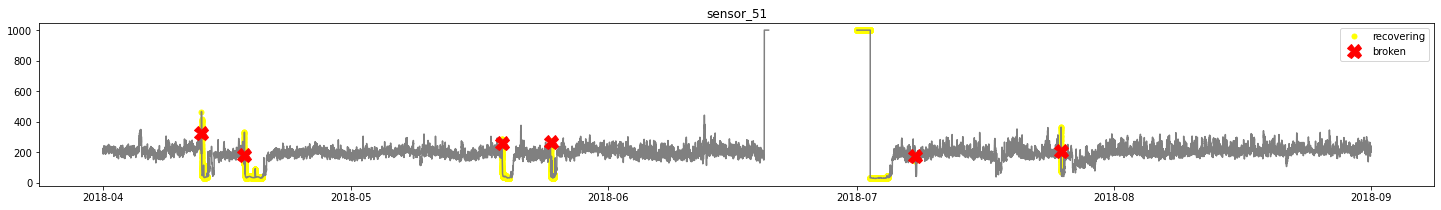

In [27]:
# plot sensor 51
plot_sensor('sensor_51')

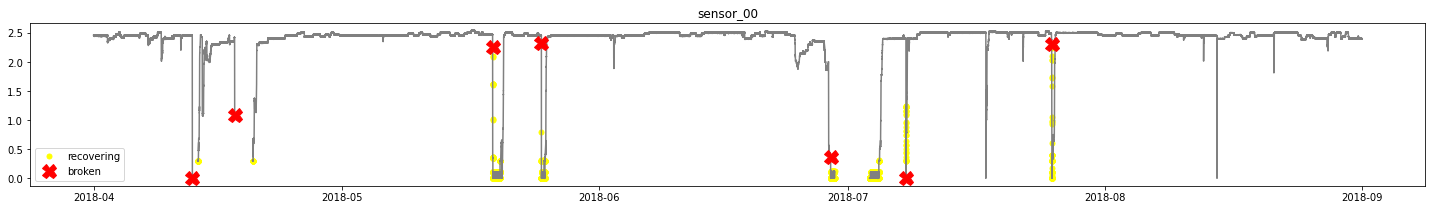

In [28]:
plot_sensor('sensor_00')

# Preprocess for machine learning

In [30]:
# use mean of the column to handle missing values and remove label in feature matrix X
m, n = df.shape
X = df.iloc[:,:n-1] # ignore machine status columns
X = X.fillna(X.mean())
X.shape

(220320, 50)

In [13]:
#scaling
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X= scaler.fit_transform(X)

In [14]:
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

outliers_fraction = 1 - (len(normal_rows)/(len(df))) 

anomaly_algorithms = [
    ("Isolation Forest",IsolationForest(contamination=outliers_fraction, n_jobs = -1)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction)),
    ("Local Outlier Factor",LocalOutlierFactor(contamination=outliers_fraction, n_jobs = -1)),
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction))]

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# ## fit the models: Mind you this takes a lot of time!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
for name, algorithm in anomaly_algorithms:
    print(algorithm)

    if name == "Local Outlier Factor":
        y_pred = algorithm.fit_predict(X)
    else:
        y_pred = algorithm.fit(X).predict(X)
    
    df[f'{name}'] = y_pred
    print('-'*100)
    print(f'number of anomolies detected')
    print(df[f'{name}'].value_counts())
    print('-'*100)


IsolationForest(contamination=0.06574074074074077, n_jobs=-1)
----------------------------------------------------------------------------------------------------
number of anomolies detected
 1    205836
-1     14484
Name: Isolation Forest, dtype: int64
----------------------------------------------------------------------------------------------------
OneClassSVM(nu=0.06574074074074077)
----------------------------------------------------------------------------------------------------
number of anomolies detected
 1    205831
-1     14489
Name: One-Class SVM, dtype: int64
----------------------------------------------------------------------------------------------------
LocalOutlierFactor(contamination=0.06574074074074077, n_jobs=-1)
----------------------------------------------------------------------------------------------------
number of anomolies detected
 1    205836
-1     14484
Name: Local Outlier Factor, dtype: int64
-------------------------------------------------------

In [15]:
#save results
filename = 'outcome.csv'
df.to_csv(filename, index=False)

In [16]:
# for name, algorithm in anomaly_algorithms:
#    anomoly_rows = df_results[df_results[f'{name}'] == -1]
#    print(anomoly_rows[['machine_status', f'{name}']])
# df = pd.read_csv('outcome.csv')

                    machine_status  Isolation Forest
timestamp                                           
2018-04-12 22:07:00     RECOVERING                -1
2018-04-12 22:08:00     RECOVERING                -1
2018-04-12 22:09:00     RECOVERING                -1
2018-04-12 22:13:00     RECOVERING                -1
2018-04-12 22:14:00     RECOVERING                -1
...                            ...               ...
2018-08-23 05:32:00         NORMAL                -1
2018-08-23 05:33:00         NORMAL                -1
2018-08-23 05:36:00         NORMAL                -1
2018-08-23 05:37:00         NORMAL                -1
2018-08-23 05:38:00         NORMAL                -1

[14484 rows x 2 columns]
                    machine_status  One-Class SVM
timestamp                                        
2018-04-02 14:04:00         NORMAL             -1
2018-04-02 14:05:00         NORMAL             -1
2018-04-02 14:06:00         NORMAL             -1
2018-04-02 14:07:00         NORMAL 

In [18]:
def plot_sensor_anomolies(sensor, name):
    anomoly_rows = df[df[f'{name}'] == -1]
    plot = plt.figure(figsize=(25,3))
    plot = plt.plot(df[sensor], color='grey')
    plot = plt.plot(recovery_rows[sensor], linestyle='none', marker='o', color='yellow', markersize=5, label='recovering',alpha = 0.5)
    plot = plt.plot(broken_rows[sensor], linestyle='none', marker='X', color='red', markersize=20, label='broken')
    plot = plt.plot(anomoly_rows[sensor], linestyle='none', marker='X', color='blue', markersize=4, label='anomoly predicted', alpha = 0.1)
    plot = plt.title(sensor)
    plot = plt.legend()
    plt.show();

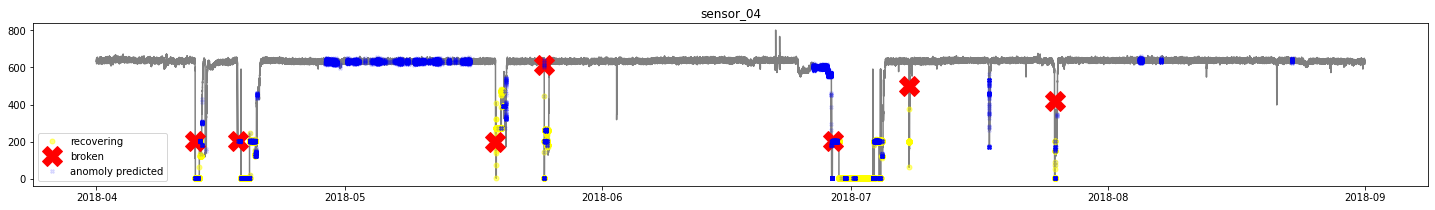

In [19]:
plot_sensor_anomolies('sensor_04', 'Isolation Forest')

Although the Isolation forest predicts anomolies near the broken points the outcome is not satisfactory.  